# Connect to Google BigQuery

In [8]:
from google.cloud import bigquery

# Set the parameters below
project = "dit-m1ia"
location = "eu"

dataset_name = "dataset_pipeline_ousmane"
raw_table_name = "temperature_humidite"
avg_table_name = "temperature_humidite_avg"

# Create client connection
client = bigquery.Client(project=project)
# Fetch the table objects
raw_table_ref = client.dataset(dataset_name).table(raw_table_name)
avg_table_ref = client.dataset(dataset_name).table(avg_table_name)

raw_table = client.get_table(raw_table_ref)
avg_table = client.get_table(avg_table_ref)
tables = [raw_table, avg_table]

# View table schema

In [9]:
from IPython.display import HTML, display
import tabulate

# Display the table schemas as tables
for table in tables:
    print("\nTable: {:15}   {} rows".format(table.table_id, table.num_rows))
    tab = []
    for schema in table.schema:
        row = [schema.name, schema.field_type]
        tab.append(row)
        
    display(HTML(tabulate.tabulate(tab, tablefmt='html')))


Table: temperature_humidite   516 rows


timestamp,TIMESTAMP
clientid,STRING
temperature,FLOAT
humidity,FLOAT



Table: temperature_humidite_avg   278 rows


timestamp,TIMESTAMP
clientid,STRING
temperature,FLOAT
humidity,FLOAT


# Query most recent rows

In [11]:
query = ("""
    SELECT
      *
    FROM
      `%s.%s.%s`
    ORDER BY
      timestamp DESC
    LIMIT
      5
    """ %(project, dataset_name, avg_table_name))

# Run the query on BigQuery
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location=location)  # API request - starts the query

# Display the rows in a tabulated format
rows = []
for row in query_job:  # API request - fetches results
    # Row values can be accessed by field name or index
    r = [row.timestamp, row.temperature, row.humidity]
    rows.append(r)
    
display(HTML(tabulate.tabulate(rows, tablefmt='html')))

2022-04-14 02:04:38+00:00,25,60
2022-04-14 02:03:36+00:00,26.6667,56.6667
2022-04-14 02:02:36+00:00,27.2,58.6
2022-04-14 02:01:36+00:00,27.5714,58.2857
2022-04-14 02:00:35+00:00,27.8889,57.6667


And the average table has 1 row per minute, showing the last 5 minutes' sliding window average values

# Query: Average temperature values for the last 24 hours

## Import maptplotlib graphing library and make a SQL query

In [13]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

query = ("""
SELECT
  timestamp, temperature, humidity
FROM
  `%s.%s.%s`
ORDER BY
  timestamp DESC
LIMIT
  1440
    """ %(project, dataset_name, avg_table_name))

# Run query to fetch metrics from the average table
query_job = client.query(query, location=location)

datetimes = []
temperature_avgs = []
humidity_avgs = []

for row in query_job:
    datetimes.append(row['timestamp'])
    temperature_avgs.append(row['temperature'])
    humidity_avgs.append(row['humidity'])

## Create a simple line chart to plot the average temperature values

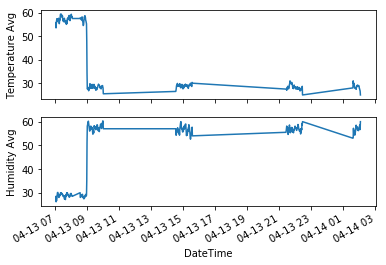

In [14]:
# Create a line chart for temperature
plt.subplot(2,1,1)
plt.plot(datetimes, temperature_avgs)
plt.gcf().autofmt_xdate()
plt.xlabel('DateTime')
plt.ylabel('Temperature Avg')

# Create a line chart for pressure
plt.subplot(2,1,2)
plt.plot(datetimes, humidity_avgs)
plt.gcf().autofmt_xdate()
plt.xlabel('DateTime')
plt.ylabel('Humidity Avg')

plt.show()

## Create a scatter chart to show the correlation between temperature and pressure values

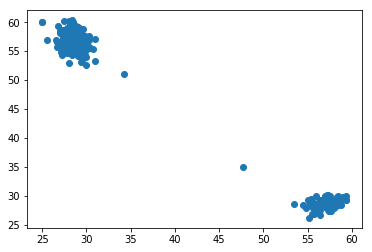

In [15]:
plt.scatter(temperature_avgs, humidity_avgs)
plt.show()